# Universal Sentence Representations
---

## Import Libraries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.datasets import SNLI
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence

## Global Configs

In [4]:
data_path = Path("data")
BATCH_SIZE = 32

# EDA

## Load Data

In [5]:
# set up fields
TEXT = torchtext.data.Field(lower=True, batch_first=True, tokenize="spacy", include_lengths=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [6]:
train_data, val_data, test_data= SNLI.splits(text_field=TEXT, label_field=LABEL, root=data_path)

In [7]:
TEXT.build_vocab(train_data, vectors=GloVe(cache=data_path))
LABEL.build_vocab(train_data)

In [8]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train_data, val_data, test_data), batch_size=BATCH_SIZE
)

## Example Batch

In [9]:
batch = next(iter(train_iter))

In [10]:
batch


[torchtext.data.batch.Batch of size 32 from SNLI]
	[.premise]:('[torch.LongTensor of size 32x26]', '[torch.LongTensor of size 32]')
	[.hypothesis]:('[torch.LongTensor of size 32x19]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

In [11]:
len(batch.premise), batch.premise[0].shape, batch.premise[1].shape

(2, torch.Size([32, 26]), torch.Size([32]))

In [12]:
batch.premise[0][0], batch.premise[1][0]

(tensor([143,  15, 168,   8,   2, 150, 113, 656,   3,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1]),
 tensor(9))

In [13]:
print(" ".join([TEXT.vocab.itos[i] for i in batch.premise[0][0]]))

several people sit on a bench watching traffic . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [14]:
print(" ".join([TEXT.vocab.itos[i] for i in batch.hypothesis[0][0]]))

several people sitting at the dinner table . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [15]:
LABEL.vocab.itos[batch.label[0]]

'contradiction'

In [16]:
LABEL.vocab.stoi

defaultdict(None, {'entailment': 0, 'contradiction': 1, 'neutral': 2})

## GloVe Embeddings

In [16]:
TEXT.vocab.vectors[batch.premise[0]].shape

torch.Size([32, 30, 300])

In [17]:
TEXT.vocab.vectors[batch.hypothesis[0]].shape

torch.Size([32, 17, 300])

## Label Distribution

labels=[]
for batch in train_iter:
    labels.append(batch.label)
labels = torch.cat(labels)
labels.shape

In [18]:
from collections import Counter

In [ ]:
labels_count = Counter(labels.tolist())
labels_count.most_common(3)

# Baseline Encoder

## Sanity Check

In [21]:
premise_emb = TEXT.vocab.vectors[batch.premise[0]]
premise_agg = torch.mean(premise_emb, dim=1)
hypothesis_emb = TEXT.vocab.vectors[batch.hypothesis[0]]
hypothesis_agg = torch.mean(hypothesis_emb, dim=1)
premise_agg.shape, hypothesis_agg.shape

(torch.Size([32, 300]), torch.Size([32, 300]))

In [22]:
diff = premise_agg - hypothesis_agg
prod = premise_agg * hypothesis_agg
diff.shape, prod.shape

(torch.Size([32, 300]), torch.Size([32, 300]))

In [23]:
x = torch.cat((premise_agg, hypothesis_agg, diff, prod), dim=1)
x.shape

torch.Size([32, 1200])

## Baseline Word Embeddings

In [24]:
class BaselineWordEmb(nn.Module):
    
    def __init__(self, embeddings):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)
    
    def forward(self, sentence):
        sentence_embed = self.emb(sentence[0])
        return torch.mean(sentence_embed, dim=1)

# Encoder: Unidirectional LSTM

## Sanity Checks without packing

In [25]:
batch


[torchtext.data.batch.Batch of size 32 from SNLI]
	[.premise]:('[torch.LongTensor of size 32x30]', '[torch.LongTensor of size 32]')
	[.hypothesis]:('[torch.LongTensor of size 32x17]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

In [26]:
batch_size = 32
seq_len = 26
input_size = 300
hidden_size = 100
num_layers = 1
num_directions = 1

In [27]:
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

In [28]:
sent_embed = TEXT.vocab.vectors[batch.premise[0]]
sent_embed.shape

torch.Size([32, 30, 300])

In [29]:
#x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)
c0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)

In [30]:
output, (hn, cn) = lstm(sent_embed, (h0,c0))

In [31]:
output.shape, hn.shape, cn.shape

(torch.Size([32, 30, 100]), torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [32]:
sent_hidden = hn.squeeze()
sent_hidden.shape

torch.Size([32, 100])

## Sanity Checks with packing

In [33]:
x_packed = pack_padded_sequence(sent_embed, lengths=batch.premise[1], batch_first=True, enforce_sorted=False)
x_packed.batch_sizes

tensor([32, 32, 32, 32, 32, 32, 32, 31, 29, 26, 24, 21, 18, 16, 14, 12, 11,  8,
         6,  4,  3,  3,  2,  2,  2,  2,  2,  2,  1,  1])

In [34]:
output, (hn, cn) = lstm(x_packed, (h0,c0))

In [35]:
sent_hidden = hn.squeeze()
sent_hidden.shape

torch.Size([32, 100])

## Unidirectional LSTM Encoder

In [50]:
class UniLSTM(nn.Module):
    
    def __init__(self, embeddings, batch_size, hidden_size=100, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(input_size=embeddings.shape[-1], hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h0 = torch.randn(num_layers, batch_size, hidden_size)
        self.c0 = torch.randn(num_layers, batch_size, hidden_size)
    
    def forward(self, sentence):
        sentence_embed = self.emb(sentence[0])
        x_packed = pack_padded_sequence(sentence_embed, lengths=sentence[1], batch_first=True, enforce_sorted=False)
        _, (sent_hidden, _) = lstm(x_packed, (self.h0, self.c0))
        return sent_hidden.squeeze() 

# Encoder: Bidirectional LSTM

## Sanity Checks 

In [51]:
batch


[torchtext.data.batch.Batch of size 32 from SNLI]
	[.premise]:('[torch.LongTensor of size 32x30]', '[torch.LongTensor of size 32]')
	[.hypothesis]:('[torch.LongTensor of size 32x17]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

In [52]:
batch_size = 32
seq_len = 26
input_size = 300
hidden_size = 100
num_layers = 1
num_directions = 2

In [53]:
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional=True)

In [54]:
sent_embed = TEXT.vocab.vectors[batch.premise[0]]
sent_embed.shape

torch.Size([32, 30, 300])

In [55]:
#x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)
c0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)

In [56]:
x_packed = pack_padded_sequence(sent_embed, lengths=batch.premise[1], batch_first=True, enforce_sorted=False)
x_packed.batch_sizes

tensor([32, 32, 32, 32, 32, 32, 32, 31, 29, 26, 24, 21, 18, 16, 14, 12, 11,  8,
         6,  4,  3,  3,  2,  2,  2,  2,  2,  2,  1,  1])

In [57]:
output, (hn, cn) = lstm(x_packed, (h0,c0))

In [58]:
hn.shape

torch.Size([2, 32, 100])

In [59]:
hn_forward = hn[0]
hn_backward = hn[1]
hn_forward.shape, hn_backward.shape

(torch.Size([32, 100]), torch.Size([32, 100]))

In [60]:
sent_bi = torch.cat((hn_forward, hn_backward), dim=1)
sent_bi.shape

torch.Size([32, 200])

## Bidirectional LSTM Encoder

In [67]:
class BiLSTM(nn.Module):
    
    def __init__(self, embeddings, batch_size, hidden_size=100, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(bidirectional=True, input_size=embeddings.shape[-1], hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h0 = torch.randn(num_layers*2, batch_size, hidden_size)
        self.c0 = torch.randn(num_layers*2, batch_size, hidden_size)
    
    def forward(self, sentence):
        sentence_embed = self.emb(sentence[0])
        x_packed = pack_padded_sequence(sentence_embed, lengths=sentence[1], batch_first=True, enforce_sorted=False)
        _, (sent_hidden, _) = lstm(x_packed, (self.h0, self.c0))
        sent_bi = torch.cat((sent_hidden[0], sent_hidden[1]), dim=1)
        return sent_bi.squeeze() 

# Encoder: Bidirectional LSTM with Max Pooling

## Sanity Checks 

In [17]:
batch


[torchtext.data.batch.Batch of size 32 from SNLI]
	[.premise]:('[torch.LongTensor of size 32x26]', '[torch.LongTensor of size 32]')
	[.hypothesis]:('[torch.LongTensor of size 32x19]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

In [18]:
batch_size = 32
seq_len = 26
input_size = 300
hidden_size = 100
num_layers = 1
num_directions = 2

In [19]:
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional=True)

In [20]:
sent_embed = TEXT.vocab.vectors[batch.premise[0]]
sent_embed.shape

torch.Size([32, 26, 300])

In [21]:
#x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)
c0 = torch.randn(num_layers*num_directions, batch_size, hidden_size)

In [22]:
x_packed = pack_padded_sequence(sent_embed, lengths=batch.premise[1], batch_first=True, enforce_sorted=False)
x_packed.batch_sizes

tensor([32, 32, 32, 32, 32, 32, 31, 28, 25, 23, 20, 15, 12, 11, 10,  9,  7,  7,
         5,  5,  3,  2,  2,  2,  1,  1])

In [36]:
output, (hn, cn) = lstm(x_packed, (h0,c0))

In [37]:
output, seq_len = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

In [43]:
output[output == 0] = -1e9
output.shape

torch.Size([32, 26, 200])

In [44]:
sent_hidden_pooled,sent_hidden_idx = torch.max(output, dim=1)
sent_hidden_pooled.shape

torch.Size([32, 200])

In [45]:
seq_len

tensor([ 9, 16,  8, 14,  8, 11, 10, 12, 11, 15, 13, 11,  6,  7, 24, 21,  7, 20,
        18, 10, 26, 11, 12,  7, 20, 16,  9, 11, 12, 10,  8, 18])

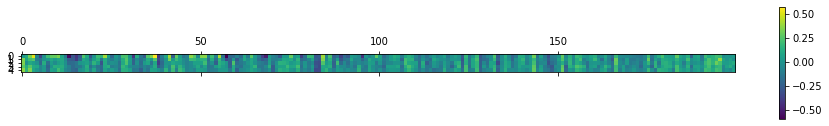

In [46]:
plt.matshow(output[2, :5].detach().numpy())
plt.colorbar()

In [47]:
output[2, :, 0]

tensor([ 2.5015e-02,  3.3774e-01,  3.4187e-01,  2.7755e-01,  3.7114e-01,
         2.6275e-01,  2.2479e-01,  1.6546e-01, -1.0000e+04, -1.0000e+04,
        -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04,
        -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04,
        -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04, -1.0000e+04,
        -1.0000e+04], grad_fn=<SelectBackward>)

In [30]:
sent_hidden_idx.shape

torch.Size([32, 200])

## Bidirectional LSTM Encoder with Max Pooling

In [99]:
class BiLSTMPool(nn.Module):
    
    def __init__(self, embeddings, batch_size, hidden_size=100, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(bidirectional=True, input_size=embeddings.shape[-1], hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h0 = torch.randn(num_layers*2, batch_size, hidden_size)
        self.c0 = torch.randn(num_layers*2, batch_size, hidden_size)
    
    def forward(self, sentence):
        sentence_embed = self.emb(sentence[0])
        x_packed = pack_padded_sequence(sentence_embed, lengths=sentence[1], batch_first=True, enforce_sorted=False)
        output, (sent_hidden, _) = lstm(x_packed, (self.h0, self.c0))
        output, seq_len = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        sent_hidden_pooled, _ = torch.max(output, dim=1)
        return sent_hidden_pooled 

# Sentence Classifier

In [100]:
class Classifier(nn.Module):
    
    def __init__(self, encoder, encoded_dim):
        super().__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(4 * encoded_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
    
    def forward(self, premise, hypothesis):
        u = self.encoder(premise)
        v = self.encoder(hypothesis)
        diff = u - v
        prod = u * v
        x = torch.cat((u, v, diff, prod), dim=1)
        return self.layers(x)

# Train Model

In [101]:
encoded_dim = TEXT.vocab.vectors.shape[-1]
encoder = BaselineWordEmb(embeddings=TEXT.vocab.vectors)
model = Classifier(encoder, encoded_dim)

NameError: name 'BaselineWordEmb' is not defined

In [70]:
encoded_dim = 100
encoder = UniLSTM(embeddings=TEXT.vocab.vectors, batch_size=BATCH_SIZE, hidden_size=encoded_dim)
model = Classifier(encoder, encoded_dim)

In [76]:
encoded_dim = 200
encoder = BiLSTM(embeddings=TEXT.vocab.vectors, batch_size=BATCH_SIZE, hidden_size=int(encoded_dim/2))
model = Classifier(encoder, encoded_dim)

In [102]:
encoded_dim = 200
encoder = BiLSTMPool(embeddings=TEXT.vocab.vectors, batch_size=BATCH_SIZE, hidden_size=int(encoded_dim/2))
model = Classifier(encoder, encoded_dim)

In [103]:
model

Classifier(
  (encoder): BiLSTMPool(
    (emb): Embedding(33672, 300)
    (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  )
  (layers): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [104]:
opt = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [105]:
pred = model(batch.premise, batch.hypothesis)
loss = criterion(pred, batch.label)
loss, pred.shape, batch.label

(tensor(1.0934, grad_fn=<NllLossBackward>),
 torch.Size([32, 3]),
 tensor([1, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0,
         1, 2, 2, 0, 2, 2, 2, 2]))

## Overfit one batch

In [106]:
iters = 1000
print_freq = 100
for idx in range(iters):
    pred = model(batch.premise, batch.hypothesis)
    loss = criterion(pred, batch.label)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if idx % print_freq == 0:
        print(f"Epoch#{idx} Loss: {loss:.3f}")

Epoch#0 Loss: 1.093
Epoch#100 Loss: 0.000
Epoch#200 Loss: 0.000


KeyboardInterrupt: 

In [107]:
pred = model(batch.premise, batch.hypothesis)
torch.argmax(pred, dim=1), batch.label

(tensor([1, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0,
         1, 2, 2, 0, 2, 2, 2, 2]),
 tensor([1, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0,
         1, 2, 2, 0, 2, 2, 2, 2]))

## Train

In [98]:
model.to(device)

Classifier(
  (encoder): UniLSTM(
    (emb): Embedding(33672, 300)
    (lstm): LSTM(300, 100, bias=32)
  )
  (layers): Sequential(
    (0): Linear(in_features=400, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [88]:
epochs = 10
print_freq = 100
for epoch in range(epochs):
    for idx, batch in enumerate(train_iter):
        pred = model(batch.premise, batch.hypothesis)
        loss = criterion(pred, batch.label)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if idx % print_freq == 0:
            print(f"Epoch#{epoch} Step#{idx} Loss: {loss:.3f}")

Epoch#0 Step#0 Loss: 2.033
Epoch#0 Step#100 Loss: 0.995
Epoch#0 Step#200 Loss: 1.178
Epoch#0 Step#300 Loss: 0.932
Epoch#0 Step#400 Loss: 0.861


KeyboardInterrupt: 

# Test

In [89]:
val_batch = next(iter(val_iter))

In [90]:
LABEL.vocab.stoi

defaultdict(None, {'entailment': 0, 'contradiction': 1, 'neutral': 2})

In [91]:
pred = model(val_batch.premise, val_batch.hypothesis)

In [92]:
def accuracy(pred, truth):
    correct = (torch.argmax(pred, dim=1) == truth).sum()
    return (correct.float() / val_batch.batch_size)

In [93]:
accuracy(pred, val_batch.label)

tensor(0.7188)

In [94]:
accuracies = []
for batch in val_iter:
    with torch.no_grad():
        pred = model(batch.premise, batch.hypothesis)
    accuracies.append(accuracy(pred, batch.label))
    #print(" ".join([TEXT.vocab.itos[i] for i in batch.premise[0]]))
    #print(" ".join([TEXT.vocab.itos[i] for i in batch.hypothesis[0]]))
    #print(torch.argmax(pred, dim=1), batch.label)
    #print()
torch.tensor(accuracies).mean()

tensor(0.5372)